In [ ]:
'''
This code make plots using  data sets that are made using emission_maps_dynamic_units code 
'''

In [6]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import random
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from yt.units import kpc, cm

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'nref11c_nref9f'
snap = 'RD0042'
halo_name = 'Tempest'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)


<>:62: SyntaxWarning: invalid escape sequence '\o'
<>:62: SyntaxWarning: invalid escape sequence '\o'
/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_57637/2228266318.py:62: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Mass [$M_{\odot}$]')
/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_57637/2228266318.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set2', 3) # Colormap for plots


/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/
/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/FRBs/res_0.14/Tempest_emission_maps.hdf5


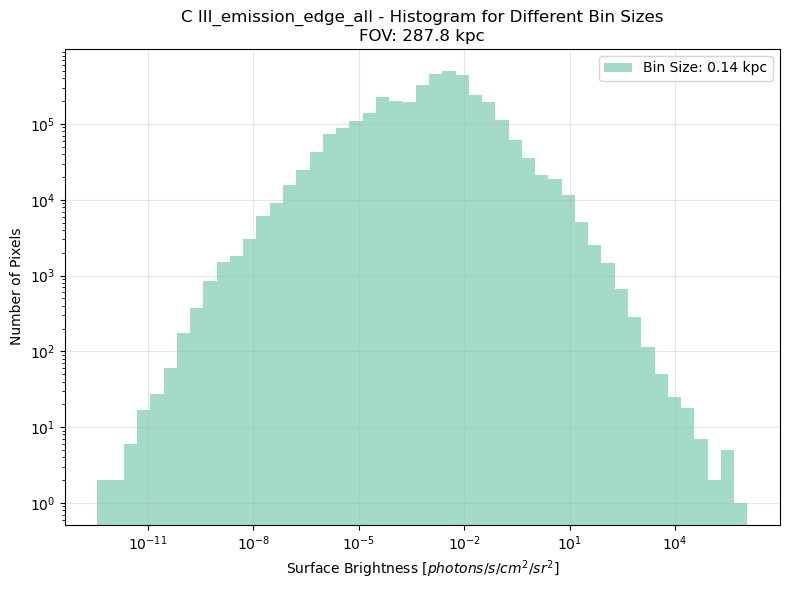

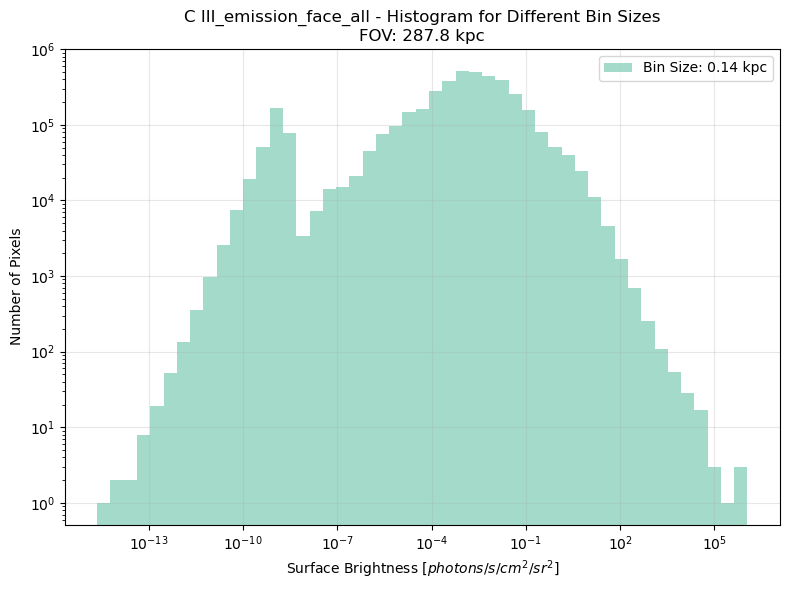

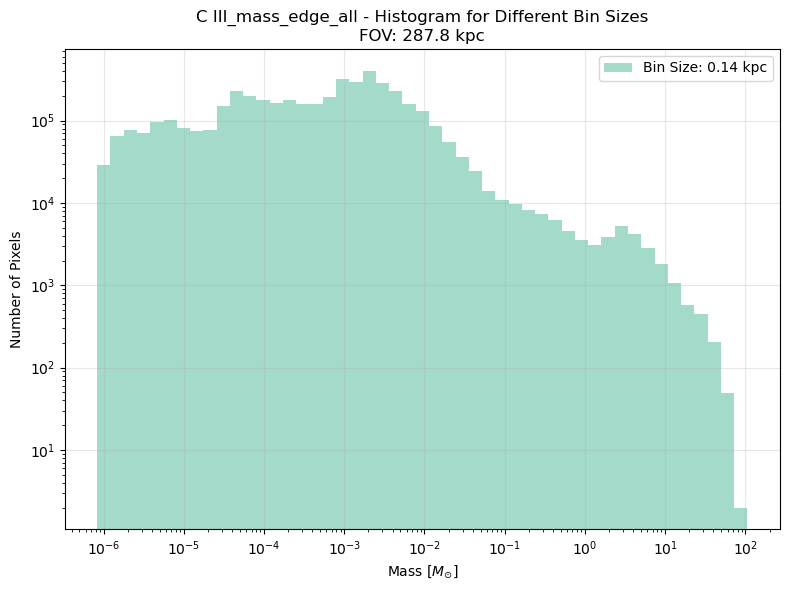

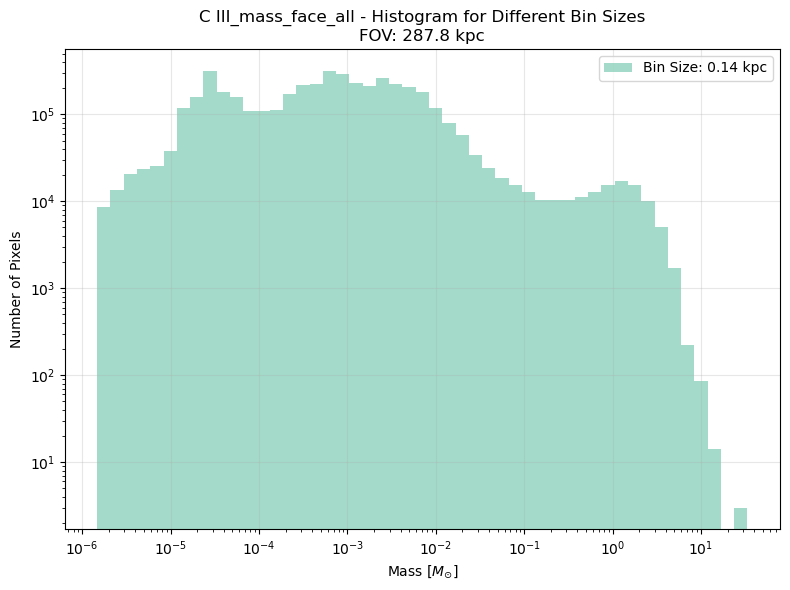

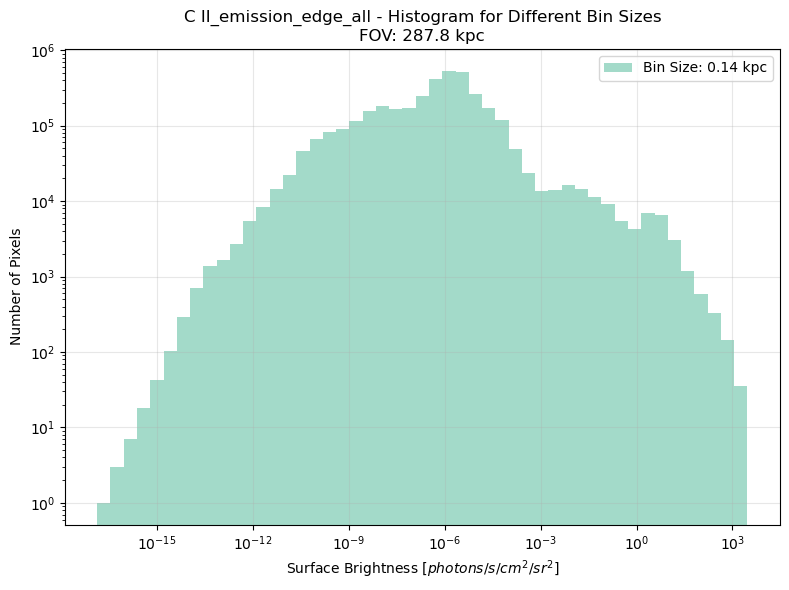

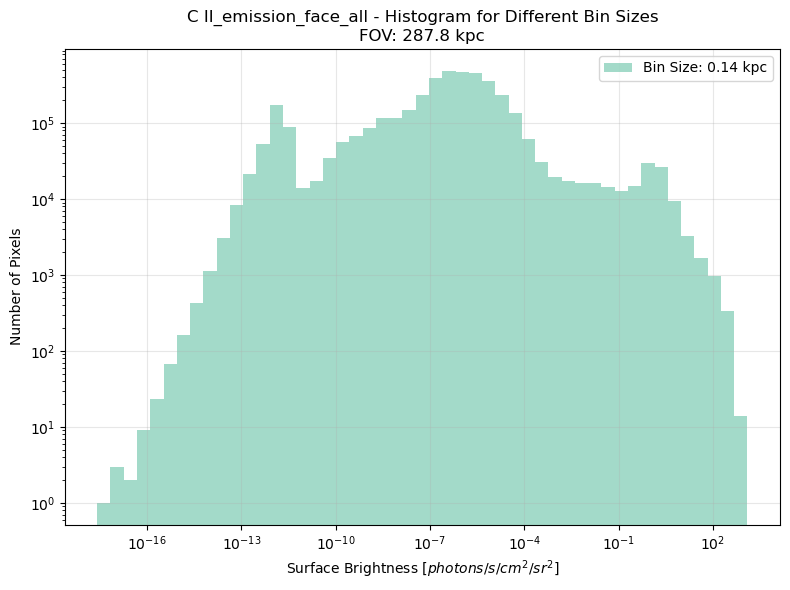

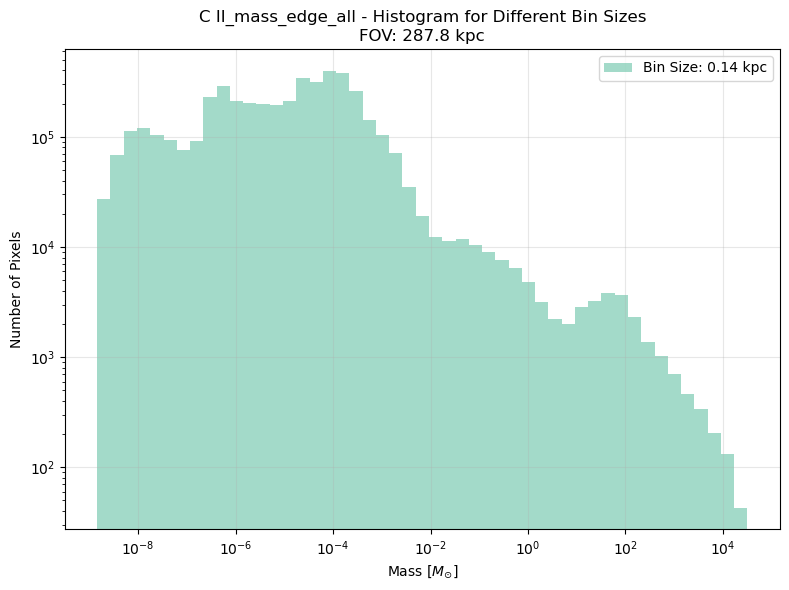

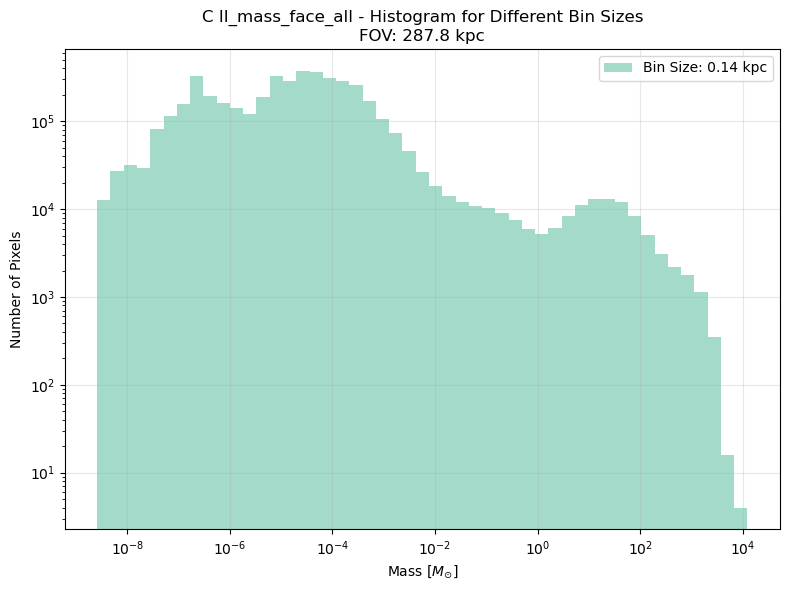

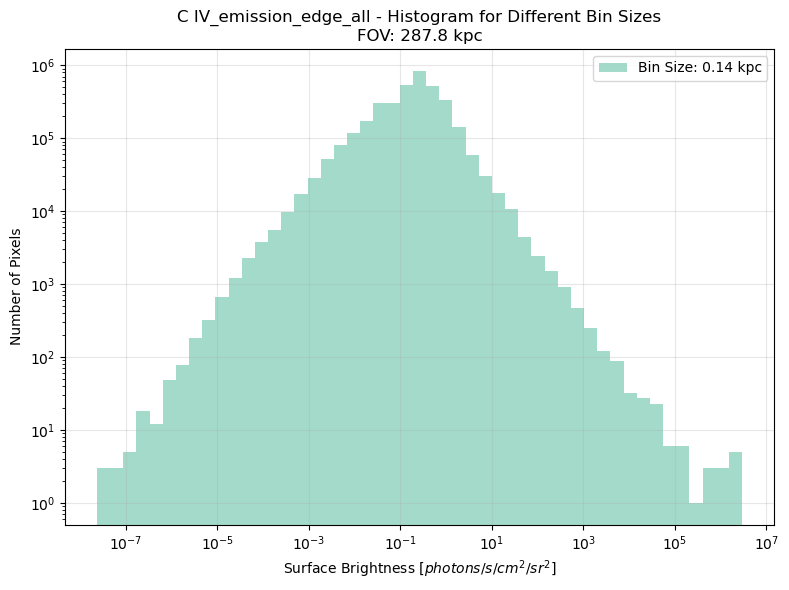

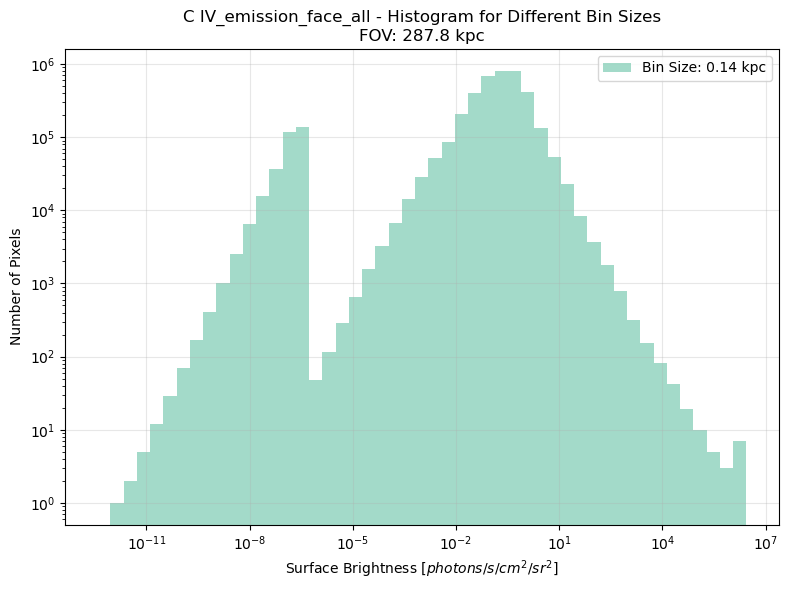

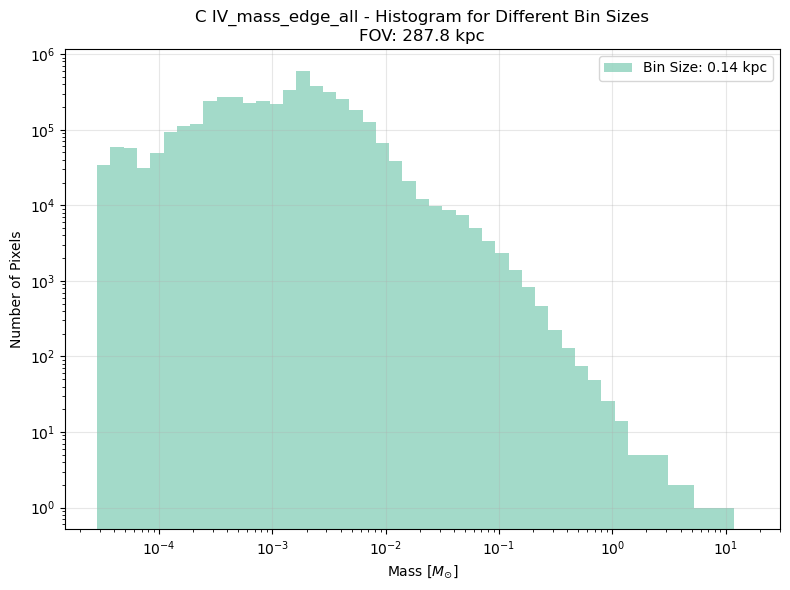

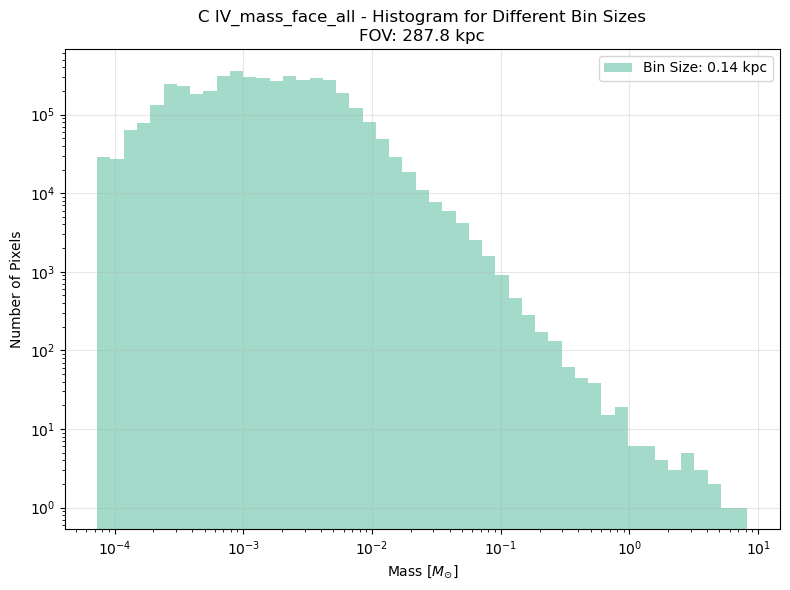

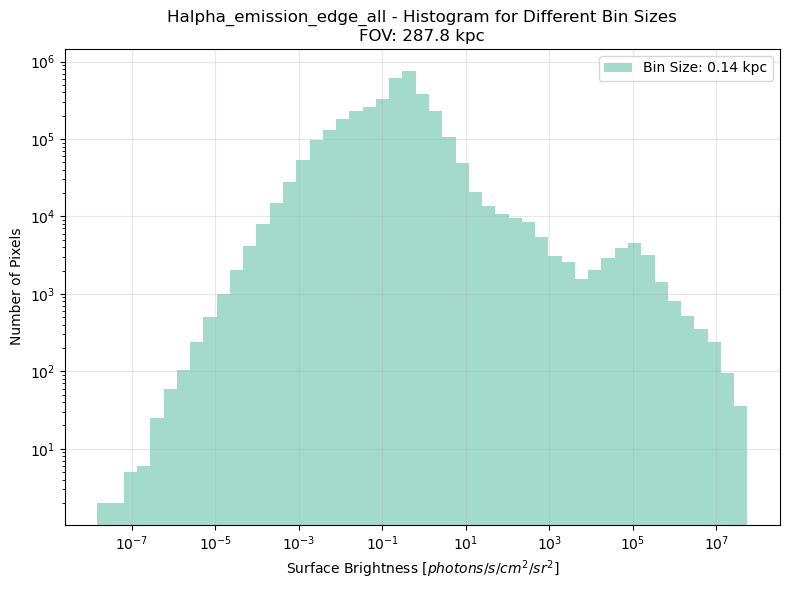

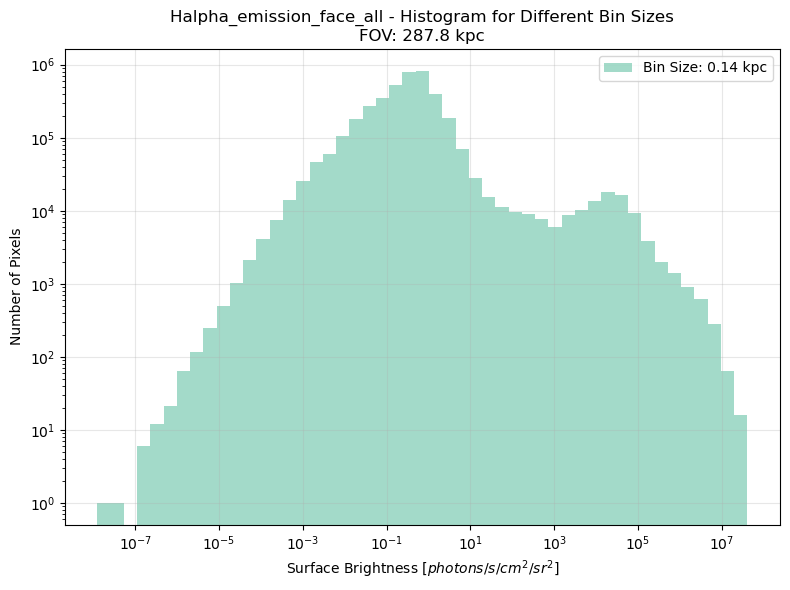

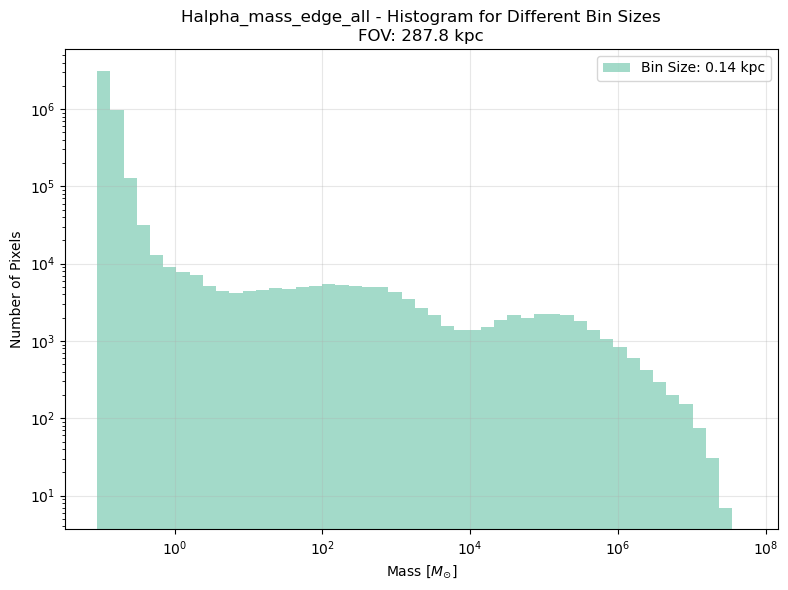

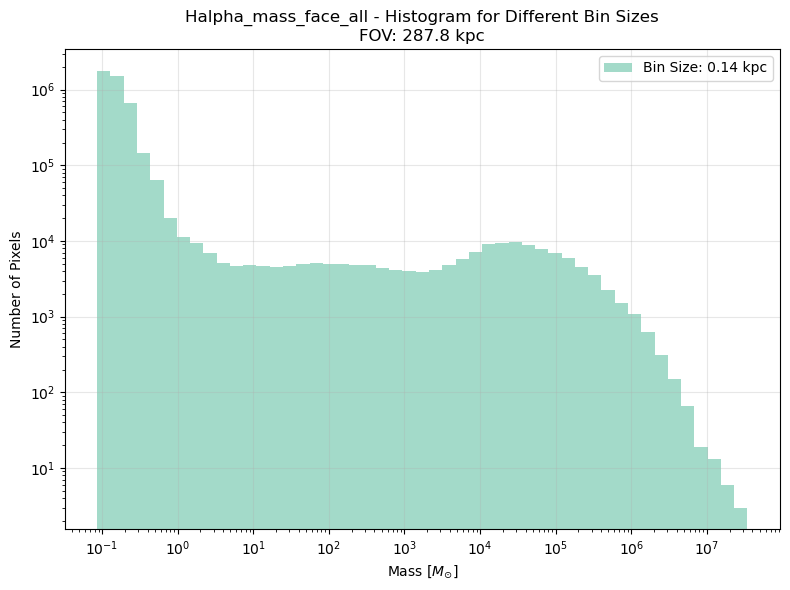

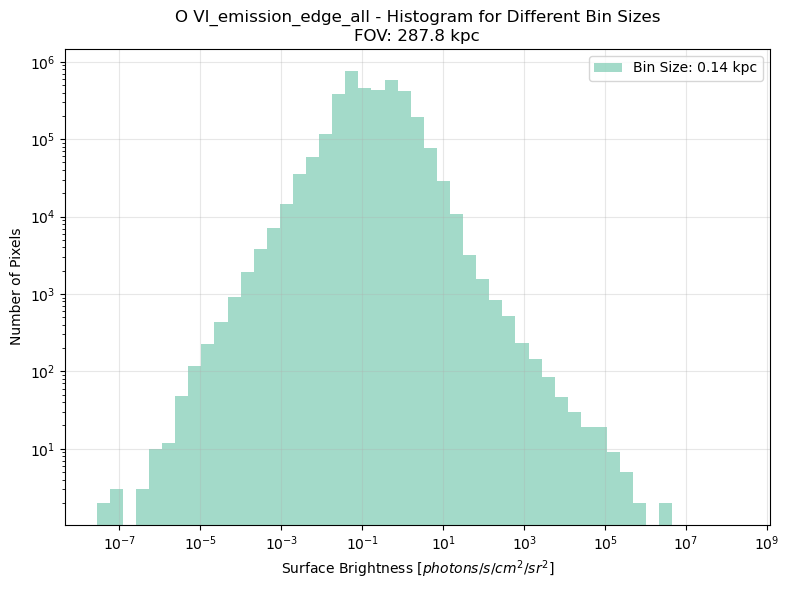

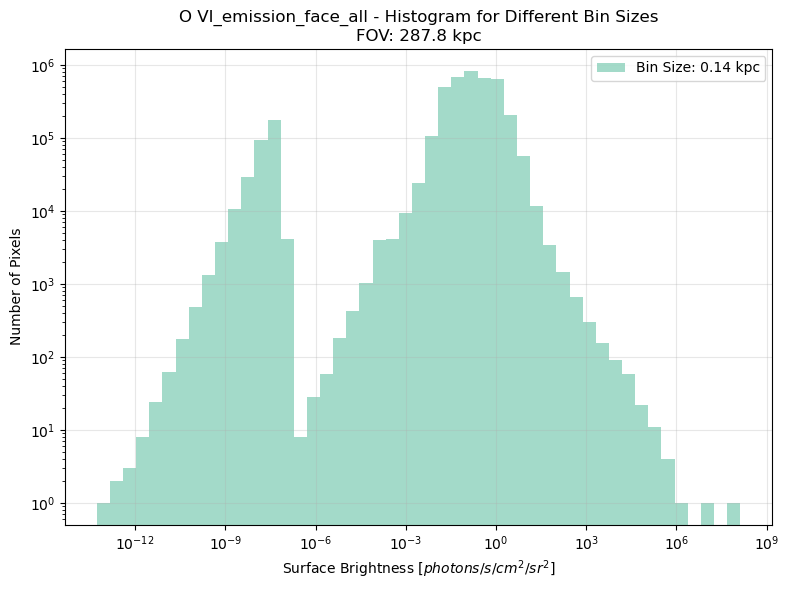

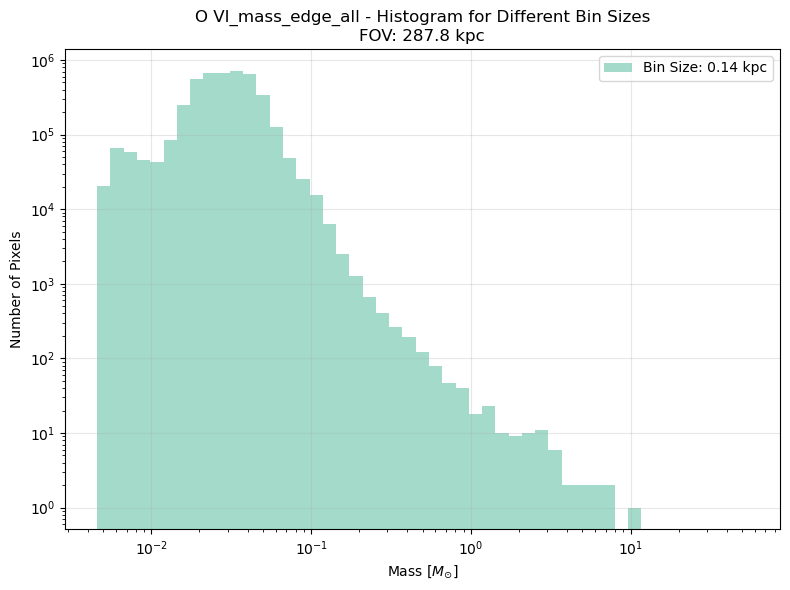

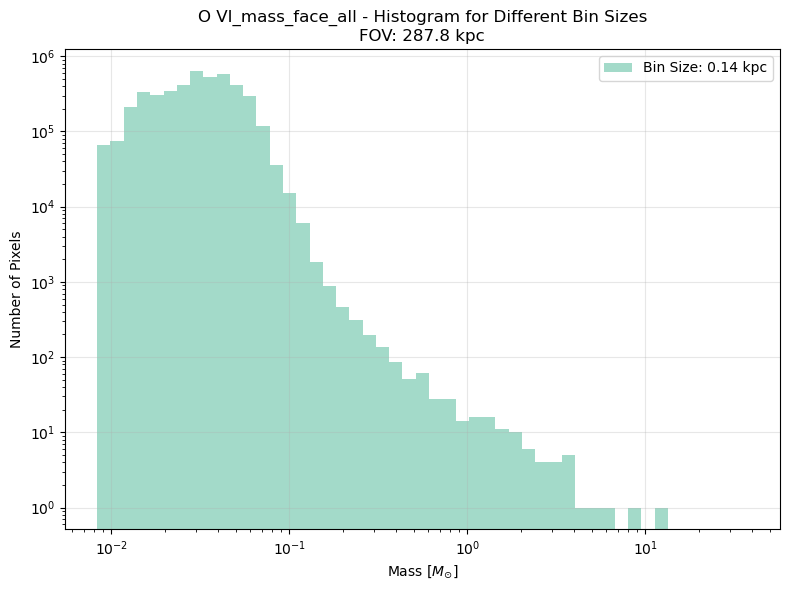

In [9]:
# Surface brightness histogram 
ions = ['Halpha']#,'C III','C II','C IV', 'O VI']
orientations = ["edge", "face"]


bin_sizes = ['0.14']#['0.342', '0.685','3.423','6.847']
flux_threshold = 1e0  # Define flux threshold
cmap = mtcm.get_cmap('Set2', 3) # Colormap for plots

prefix = output_dir + '/' + 'ions_halo_00' + halo + '/' + run + '/'
print(prefix)
# Extract all dataset names dynamically from one of the HDF5 files
example_bin_size = bin_sizes[0]
example_save_path = prefix + f'FRBs/res_{example_bin_size}/'
example_file_path = example_save_path + halo_name + '_emission_maps' + '.hdf5'
print(example_file_path)
# Open the example HDF5 file to get the dataset names
with h5py.File(example_file_path, 'r') as example_file:
    set_of_datasets = list(next(iter(example_file.values())).keys())  # Extract dataset names

# Iterate over datasets
for dataset_name in set_of_datasets:
    plt.figure(figsize=(8, 6))  # Initialize the figure for each dataset

    for i, bin_size_kpc in enumerate(bin_sizes):
        color = cmap(i)  # Choose color from colormap based on index
        save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
        file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

        # Open the HDF5 file and iterate through redshifts and datasets
        with h5py.File(file_path, 'r') as f:
            for redshift_group in f.keys():  # Iterate through redshift groups
                redshift_data = f[redshift_group]

                # Extract FOV, resolution, and bin size from the attributes
                fov_kpc = redshift_data.attrs.get("image_extent_kpc", "FOV Unknown")
                resolution = redshift_data.attrs.get("number_of_bins", "Unknown")

                if fov_kpc != "FOV Unknown":
                    fov_kpc = round(fov_kpc, 1)  # Round FOV to one decimal place

                # Get the dataset for the current bin size
                if dataset_name in redshift_data.keys():
                    # in dataset_name include mass in the name then:
                    if 'mass' in dataset_name.lower(): #.lower() method ensures the checks are case-insensitive.

                        mass_data = np.array(redshift_data[dataset_name])

                        # Flatten the emission data to calculate flux per pixel
                        mass_per_pixel = mass_data.flatten()

                        # Define log-spaced bins
                        mass_min = mass_per_pixel[mass_per_pixel > 1e-40].min()  # Avoid bins starting at 0
                        mass_max = mass_per_pixel.max()
                        bins = np.logspace(np.log10(mass_min), np.log10(mass_max), 50)  # 50 log-spaced bins

                        # Add histogram for this bin size
                        plt.hist(mass_per_pixel, bins=bins, color=color, alpha=0.6,
                                label=f'Bin Size: {bin_size_kpc} kpc')
                        
                        # Finalize the plot for this dataset
                        plt.yscale('log')  # Use logarithmic scale for better visibility
                        plt.xscale('log')  # Log scale for x-axis
                        plt.xlabel('Mass [$M_{\odot}$]')
                        plt.ylabel('Number of Pixels')
                        plt.title(f'{dataset_name} - Histogram for Different Bin Sizes\nFOV: {fov_kpc} kpc')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()

                    #if it include emission then
                    elif 'emission' in dataset_name.lower():
                        emission_data = np.array(redshift_data[dataset_name])

                        # Flatten the emission data to calculate flux per pixel
                        flux_per_pixel = emission_data.flatten()

                        # Define log-spaced bins
                        flux_min = flux_per_pixel[flux_per_pixel > 1e-40].min()  # Avoid bins starting at 0
                        flux_max = flux_per_pixel.max()
                        bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 50)  # 50 log-spaced bins

                        # Add histogram for this bin size
                        plt.hist(flux_per_pixel, bins=bins, color=color, alpha=0.6,
                                label=f'Bin Size: {bin_size_kpc} kpc')
                        
                        # Finalize the plot for this dataset
                        plt.yscale('log')  # Use logarithmic scale for better visibility
                        plt.xscale('log')  # Log scale for x-axis
                        plt.xlabel('Surface Brightness [$photons/s/cm^2/sr^2$]') 
                        plt.ylabel('Number of Pixels')
                        plt.title(f'{dataset_name} - Histogram for Different Bin Sizes\nFOV: {fov_kpc} kpc')
                        plt.legend()
                        plt.grid(True, alpha=0.3)
                        plt.tight_layout()
    
    

    # Save the combined plot in a directory for all resolutions
    combined_dir = os.path.join(prefix, "combined_histograms", redshift_group)
    os.makedirs(combined_dir, exist_ok=True)
    plt.savefig(os.path.join(combined_dir, f"{dataset_name}_combined_histogram.png"))
    plt.show()
    plt.close()


In [10]:
# Open the HDF5 file in read mode
with h5py.File(file_path, 'r') as f:
    # Recursively print all groups and datasets in the file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Data Type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
    
    f.visititems(print_structure)

Group: z=0.0
Dataset: z=0.0/C III_emission_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C III_emission_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C III_mass_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C III_mass_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C II_emission_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C II_emission_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C II_mass_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C II_mass_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C IV_emission_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C IV_emission_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C IV_mass_edge_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/C IV_mass_face_all, Shape: (2097, 2097), Data Type: float64
Dataset: z=0.0/Halpha_emission_edge_all, Shape: (2097, 2097

Ion: C IV
  Orientation: edge
    Bin Size: 0.342 kpc
      Mass Total: 1.172e+04
      Emission Total: 2.782e-15
    Bin Size: 0.685 kpc
      Mass Total: 1.155e+04
      Emission Total: 9.778e-17
    Bin Size: 3.423 kpc
      Mass Total: 1.286e+04
      Emission Total: 2.308e-17
    Bin Size: 6.847 kpc
      Mass Total: 1.609e+04
      Emission Total: 1.682e-17


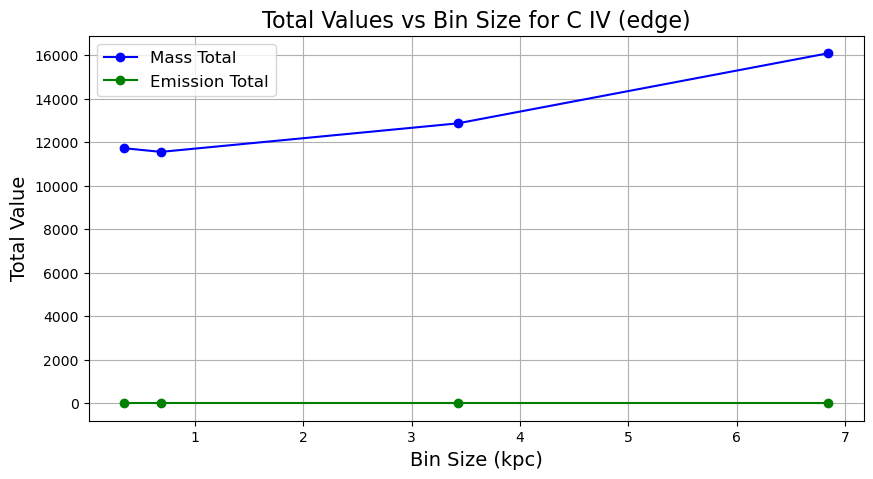

  Orientation: face
    Bin Size: 0.342 kpc
      Mass Total: 1.161e+04
      Emission Total: 8.112e-16
    Bin Size: 0.685 kpc
      Mass Total: 1.163e+04
      Emission Total: 2.444e-16
    Bin Size: 3.423 kpc
      Mass Total: 1.238e+04
      Emission Total: 1.370e-16
    Bin Size: 6.847 kpc
      Mass Total: 1.491e+04
      Emission Total: 1.333e-16


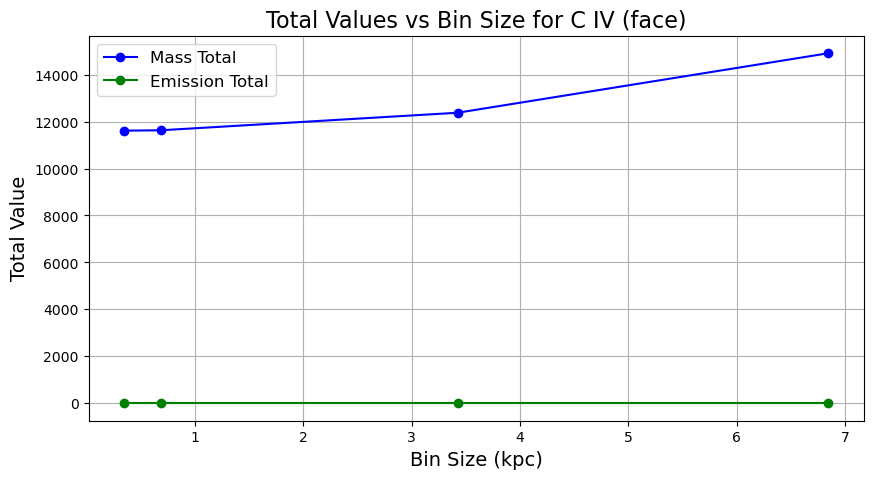

Ion: O VI
  Orientation: edge
    Bin Size: 0.342 kpc
      Mass Total: 1.383e+05
      Emission Total: 1.080e-15
    Bin Size: 0.685 kpc
      Mass Total: 1.383e+05
      Emission Total: 4.817e-16
    Bin Size: 3.423 kpc
      Mass Total: 1.387e+05
      Emission Total: 2.973e-17
    Bin Size: 6.847 kpc
      Mass Total: 1.417e+05
      Emission Total: 2.224e-17


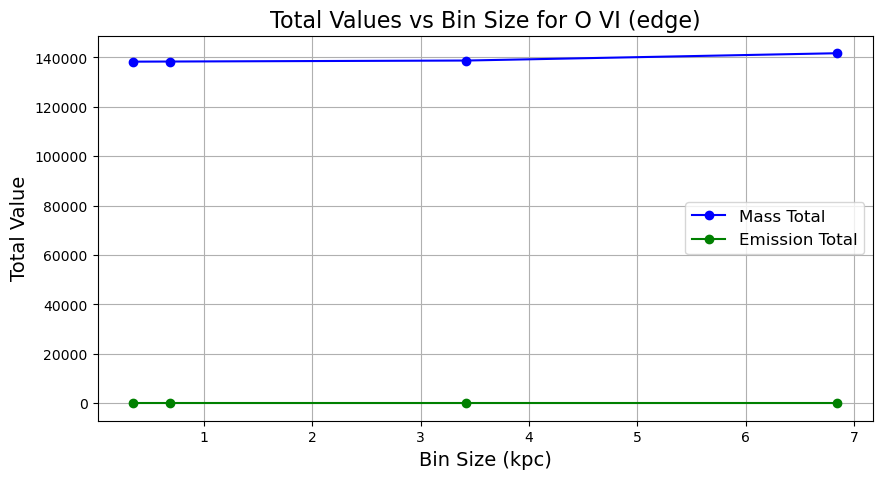

  Orientation: face
    Bin Size: 0.342 kpc
      Mass Total: 1.457e+05
      Emission Total: 1.294e-15
    Bin Size: 0.685 kpc
      Mass Total: 1.456e+05
      Emission Total: 4.433e-16
    Bin Size: 3.423 kpc
      Mass Total: 1.445e+05
      Emission Total: 3.702e-17
    Bin Size: 6.847 kpc
      Mass Total: 1.433e+05
      Emission Total: 3.473e-17


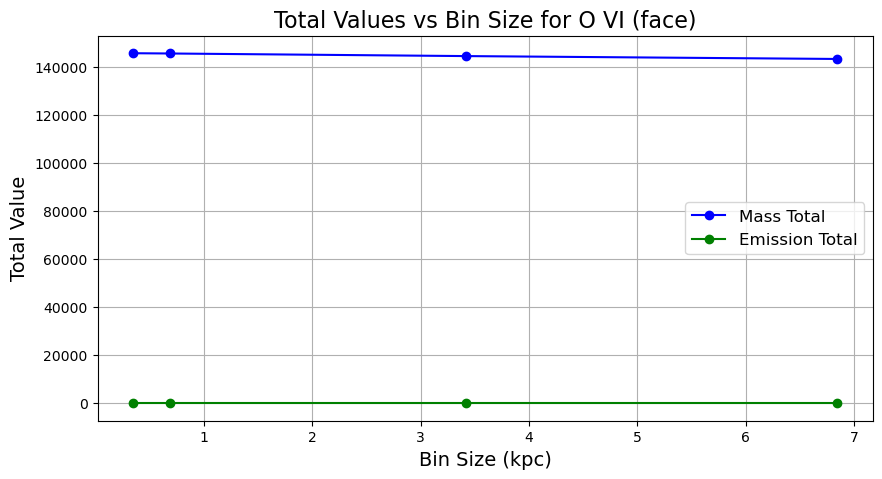

In [6]:

# Loop through ions and orientations
for ion in ions:
    print(f"Ion: {ion}")
    for orientation in orientations:
        print(f"  Orientation: {orientation}")
        
        # Initialize dictionaries to store totals for each bin size
        mass_totals = {}
        emission_totals = {}
        
        # Loop through bin sizes
        for i, bin_size_kpc in enumerate(bin_sizes):
            # Construct file path
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps.hdf5'

            try:
                # Open the HDF5 file
                with h5py.File(file_path, 'r') as f:
                    # Dataset names for mass and emission
                    mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
                    emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"
                    
                    # Load datasets and calculate total
                    mass_data = np.array(f[mass_dataset_name])
                    emission_data = np.array(f[emission_dataset_name])
                    mass_totals[bin_size_kpc] = np.sum(mass_data)
                    emission_totals[bin_size_kpc] = np.sum(emission_data)
                    
                    print(f"    Bin Size: {bin_size_kpc} kpc")
                    print(f"      Mass Total: {mass_totals[bin_size_kpc]:.3e}")
                    print(f"      Emission Total: {emission_totals[bin_size_kpc]:.3e}")
            except Exception as e:
                print(f"    Error with bin size {bin_size_kpc}: {e}")
        
        # Plot results
        plt.figure(figsize=(10, 5))
        bin_sizes_float = [float(b) for b in bin_sizes]
        
        # Plot mass totals
        plt.plot(bin_sizes_float, [mass_totals[b] for b in bin_sizes], marker='o', label='Mass Total', color='blue')
        # Plot emission totals
        plt.plot(bin_sizes_float, [emission_totals[b] for b in bin_sizes], marker='o', label='Emission Total', color='green')
        
        # Add labels and title
        plt.xlabel("Bin Size (kpc)", fontsize=14)
        plt.ylabel("Total Value", fontsize=14)
        plt.title(f"Total Values vs Bin Size for {ion} ({orientation})", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid()
        
        # Show the plot
        plt.show()


ion Halpha
orientation edge


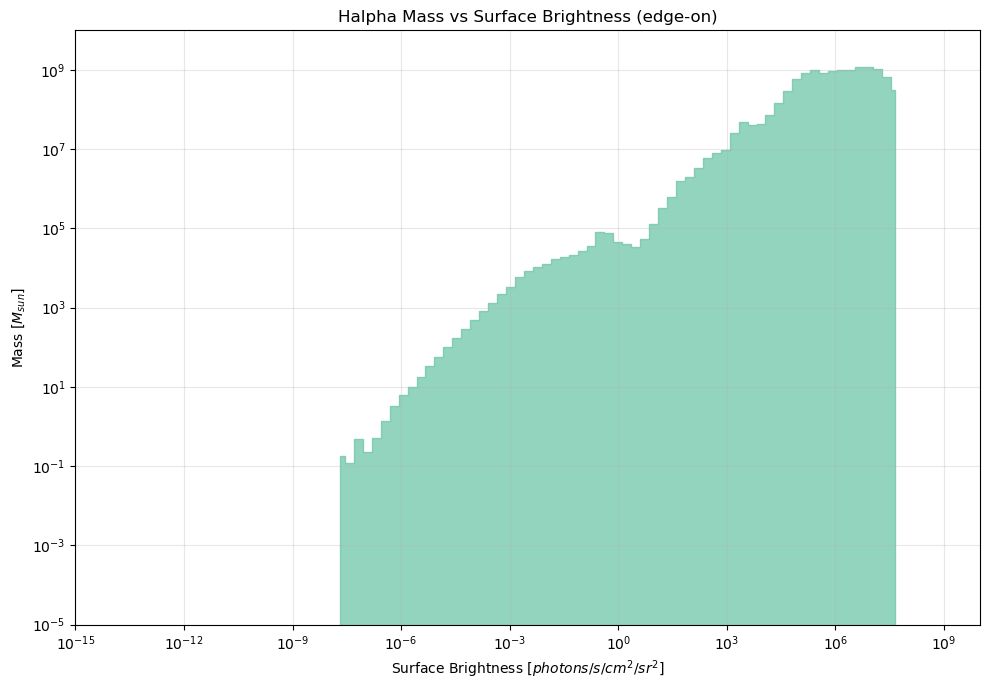

orientation face


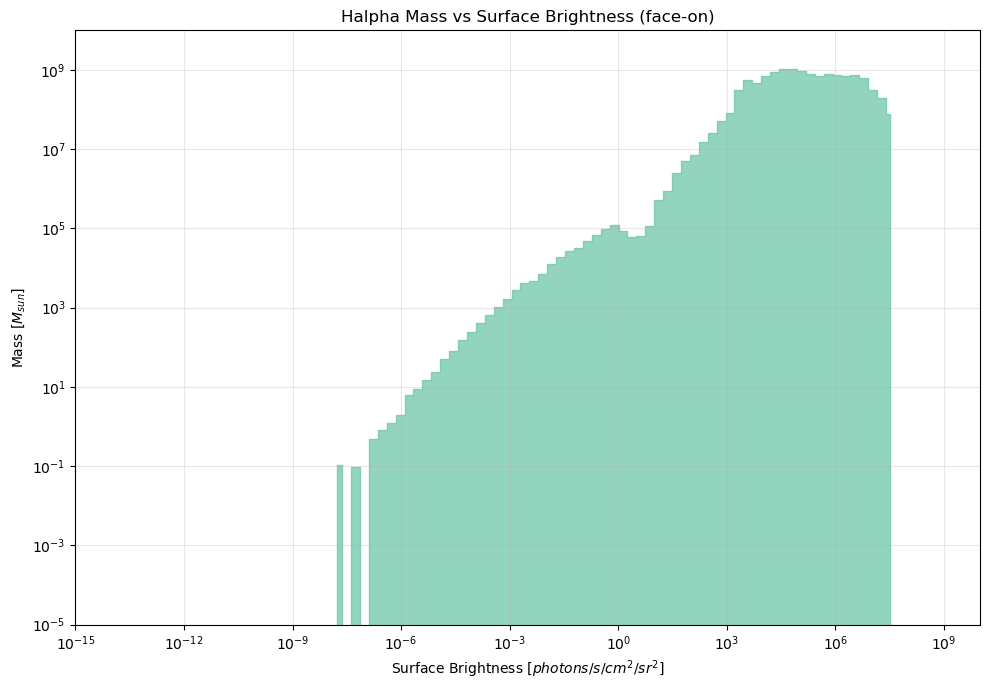

In [13]:
# make mass vs surfave brightness 
for ion in ions:
    print('ion',ion)
    for orientation in orientations:
        print('orientation',orientation)
        plt.figure(figsize=(10, 7))
        
        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
                total_surface_density = emission_data.sum()
                

                # Filter valid values
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
                emission_data = emission_data[valid_indices]
                mass_data = mass_data[valid_indices]

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 64)

                # Calculate total mass per bin
                bin_indices = np.digitize(emission_data, bins)
                mass_per_bin = [mass_data[bin_indices == j].sum() for j in range(1, len(bins))]

                # Plot the results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.fill_between(bin_centers, mass_per_bin, step='mid', color=color, alpha=0.7,
                                    label=f'Bin Size: {bin_size_kpc} kpc')

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Surface Brightness [$photons/s/cm^2/sr^2$]')
        plt.ylabel('Mass [$M_{sun}$]')
        plt.xlim(1e-15,1e10)
        plt.ylim(1e-5,1e10)
        plt.title(f'{ion} Mass vs Surface Brightness ({orientation}-on)')
        #plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_mass_vs_emission.png"))
        plt.show()
        plt.close()


ion C IV
orientation edge


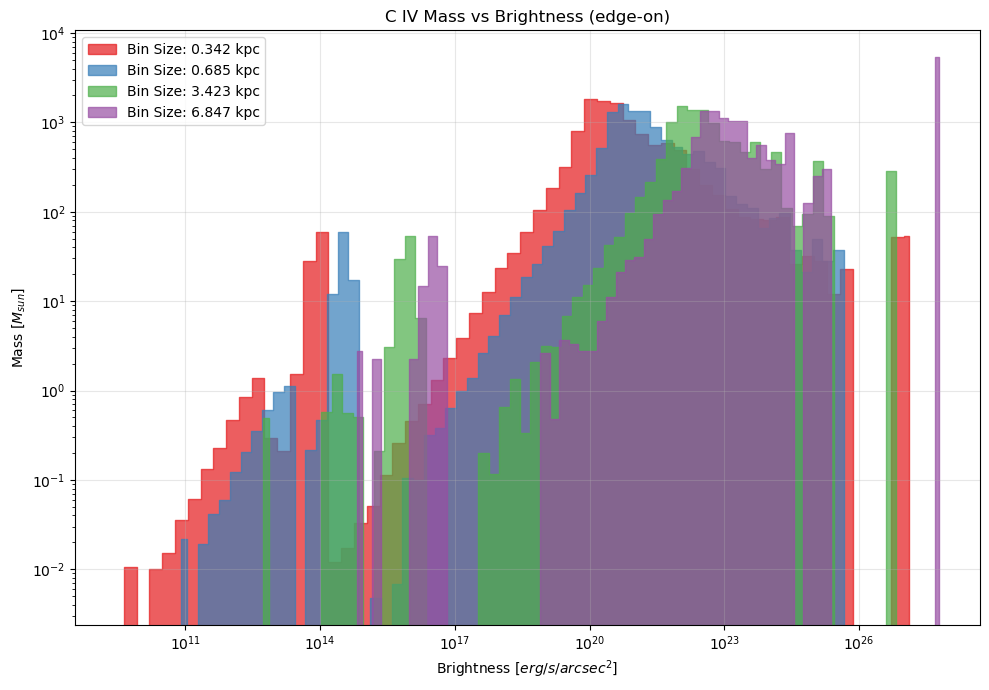

orientation face


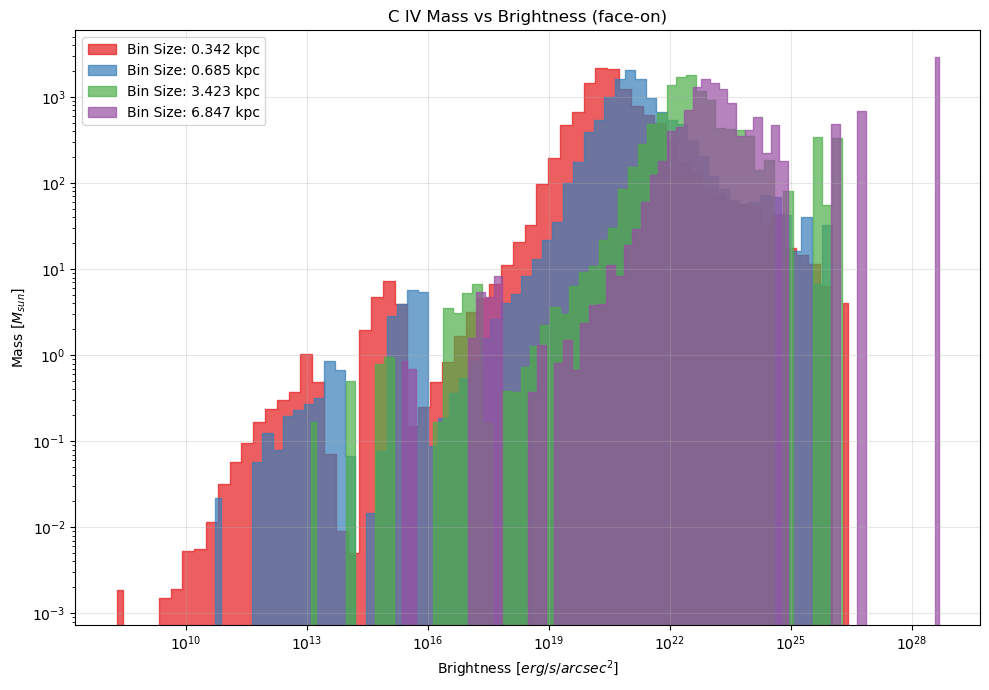

ion O VI
orientation edge


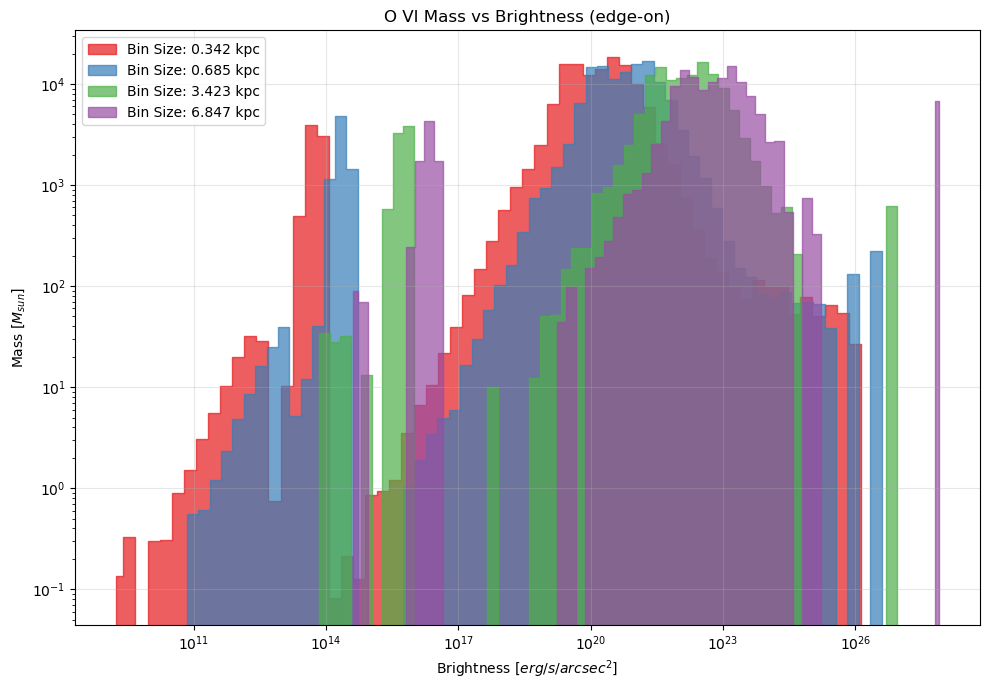

orientation face


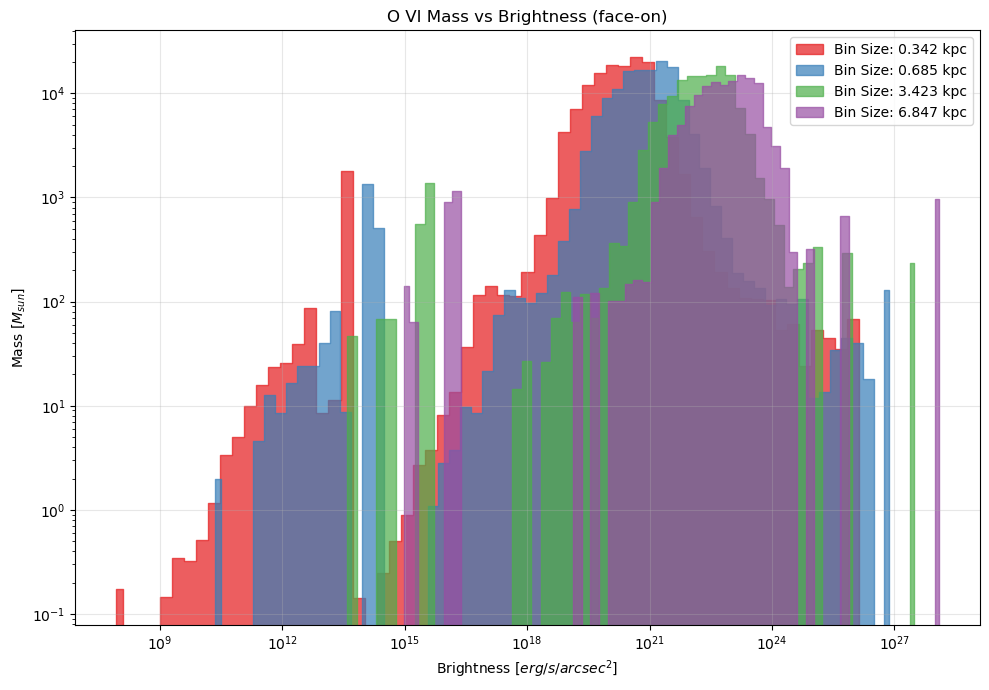

In [8]:
# Iterate over ions and orientations

for ion in ions:
    print('ion',ion)
    for orientation in orientations:
        print('orientation',orientation)
        plt.figure(figsize=(10, 7))
        
        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
               

                # Filter valid values
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
                emission_data = emission_data[valid_indices]*((float(bin_size_kpc)*3.086e21)**2)
                total_emission = emission_data.sum()
                mass_data = mass_data[valid_indices]
                

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 64)

                # Calculate total mass per bin
                bin_indices = np.digitize(emission_data, bins)
                mass_per_bin = [mass_data[bin_indices == j].sum() for j in range(1, len(bins))]

                # Plot the results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.fill_between(bin_centers, mass_per_bin, step='mid', color=color, alpha=0.7,
                                    label=f'Bin Size: {bin_size_kpc} kpc')

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Brightness [$erg/s/arcsec^2$]')
        plt.ylabel('Mass [$M_{sun}$]')
        plt.title(f'{ion} Mass vs Brightness ({orientation}-on)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_flux_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_mass_vs_emission.png"))
        plt.show()
        plt.close()


ion Halpha
orientation edge
total mass 11325609369.633776


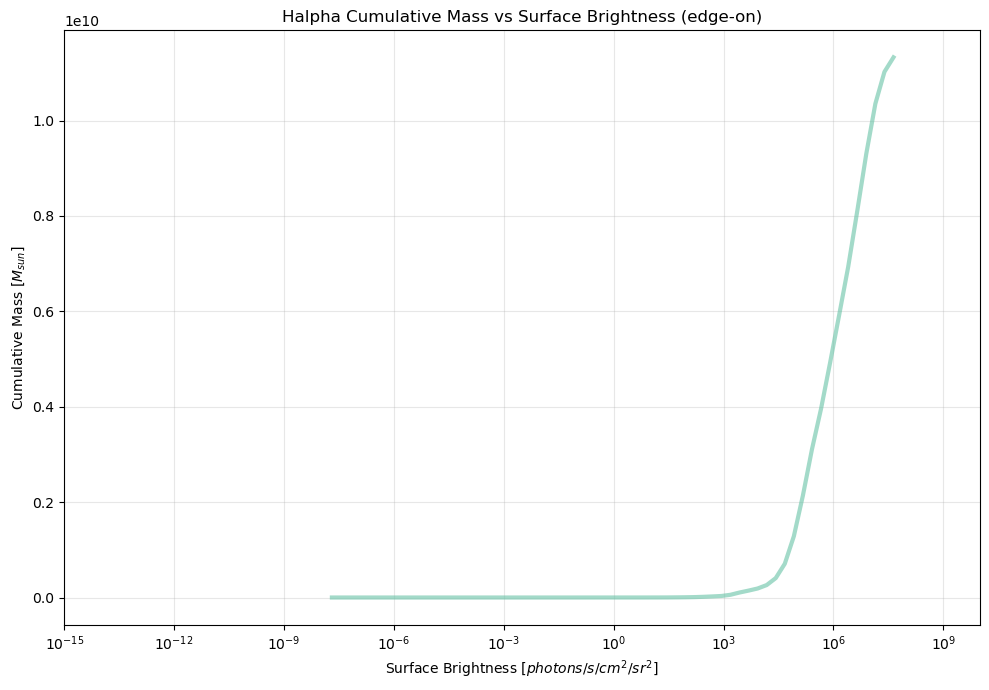

orientation face
total mass 11974536436.933989


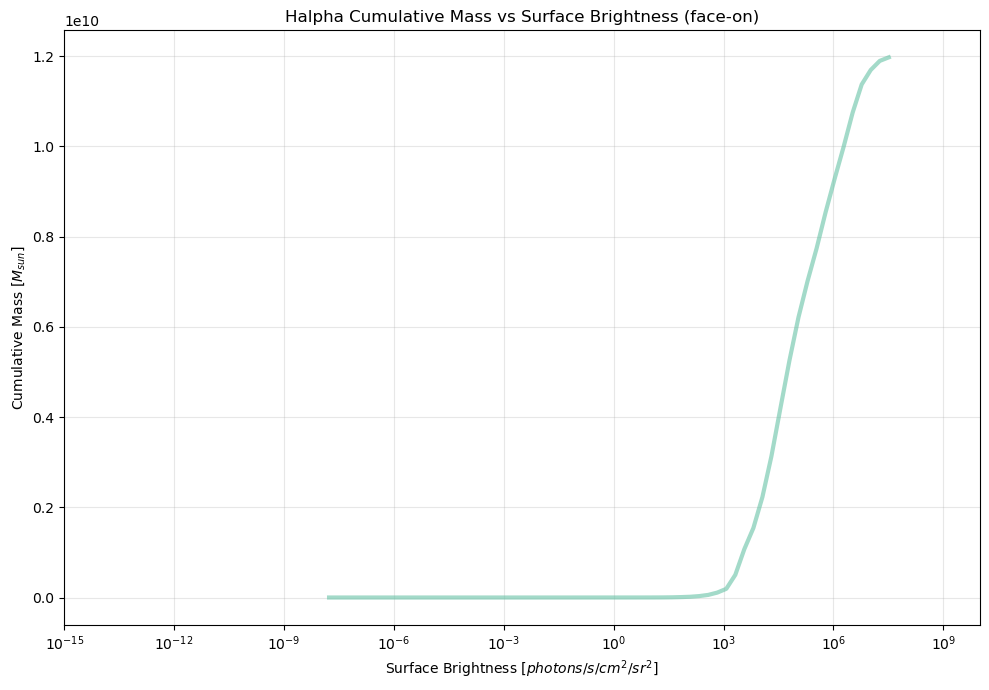

In [14]:
# Iterate over ions and orientations

for ion in ions:
    print('ion', ion)
    for orientation in orientations:
        print('orientation', orientation)
        plt.figure(figsize=(10, 7))

        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
                print('total mass', total_mass)

                
                # Use yt units to convert bin size and compute area
                bin_size = float(bin_size_kpc) * kpc  # Bin size in kpc
                bin_area = bin_size.to(cm)**2  # Area in cm^2

                # Filter valid values
                # Multiply surface brightness to get brightness
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
      
      
                emission_data = emission_data[valid_indices] #* bin_area
                mass_data = mass_data[valid_indices]

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 64)

                # Calculate cumulative mass for each bin
                bin_indices = np.digitize(emission_data, bins)
                cumulative_mass = np.array([mass_data[bin_indices <= j].sum() for j in range(1, len(bins))])

                # Plot the cumulative results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.plot(bin_centers, cumulative_mass, color=color, alpha=0.6, label=f'Bin Size: {bin_size_kpc} kpc', lw = 3)

        # Finalize the plot for this ion and orientation
        #plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Surface Brightness [$photons/s/cm^2/sr^2$]')
        plt.ylabel('Cumulative Mass [$M_{sun}$]')
        plt.xlim(1e-15,1e10)
        #plt.ylim(1e-1,160000)
        plt.title(f'{ion} Cumulative Mass vs Surface Brightness ({orientation}-on)')
        #plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_cumulative_mass_vs_emission.png"))
        plt.show()
        plt.close()


Ion: C IV
Orientation: edge
emission_data min 1977638987.5148969
Bin Size: 0.342 kpc
Total Flux: 3.10e+27, Flux Above Threshold: 2.99e+27, Flux Ratio: 0.96
Total Mass: 1.16e+04, Mass Above Threshold: 1.50e+03, Mass Ratio: 0.13
emission_data min 57255691241.4848
Bin Size: 0.685 kpc
Total Flux: 4.37e+26, Flux Above Threshold: 3.55e+26, Flux Ratio: 0.81
Total Mass: 1.14e+04, Mass Above Threshold: 2.50e+03, Mass Ratio: 0.22
emission_data min 3941227308894.2485
Bin Size: 3.423 kpc
Total Flux: 2.58e+27, Flux Above Threshold: 2.56e+27, Flux Ratio: 0.99
Total Mass: 1.27e+04, Mass Above Threshold: 1.01e+04, Mass Ratio: 0.79
emission_data min 500321959017585.8
Bin Size: 6.847 kpc
Total Flux: 7.51e+27, Flux Above Threshold: 7.51e+27, Flux Ratio: 1.00
Total Mass: 1.60e+04, Mass Above Threshold: 1.53e+04, Mass Ratio: 0.96


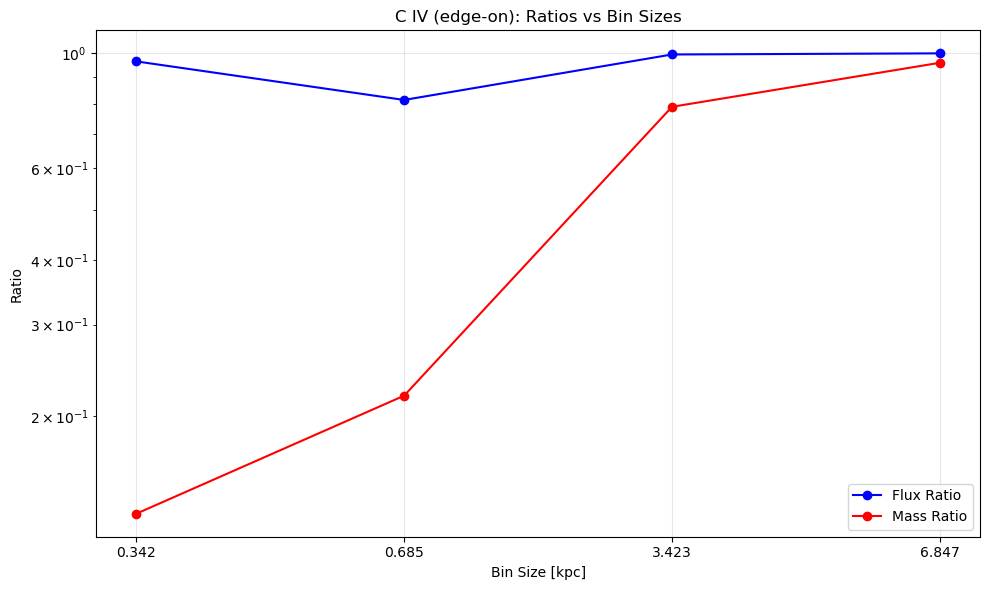

Orientation: face
emission_data min 131102389.33484471
Bin Size: 0.342 kpc
Total Flux: 9.04e+26, Flux Above Threshold: 7.79e+26, Flux Ratio: 0.86
Total Mass: 1.15e+04, Mass Above Threshold: 9.17e+02, Mass Ratio: 0.08
emission_data min 37629547818.78355
Bin Size: 0.685 kpc
Total Flux: 1.09e+27, Flux Above Threshold: 1.00e+27, Flux Ratio: 0.92
Total Mass: 1.15e+04, Mass Above Threshold: 2.01e+03, Mass Ratio: 0.17
emission_data min 9276001762061.814
Bin Size: 3.423 kpc
Total Flux: 1.53e+28, Flux Above Threshold: 1.53e+28, Flux Ratio: 1.00
Total Mass: 1.23e+04, Mass Above Threshold: 9.92e+03, Mass Ratio: 0.81
emission_data min 1797706043815684.0
Bin Size: 6.847 kpc
Total Flux: 5.95e+28, Flux Above Threshold: 5.95e+28, Flux Ratio: 1.00
Total Mass: 1.48e+04, Mass Above Threshold: 1.42e+04, Mass Ratio: 0.96


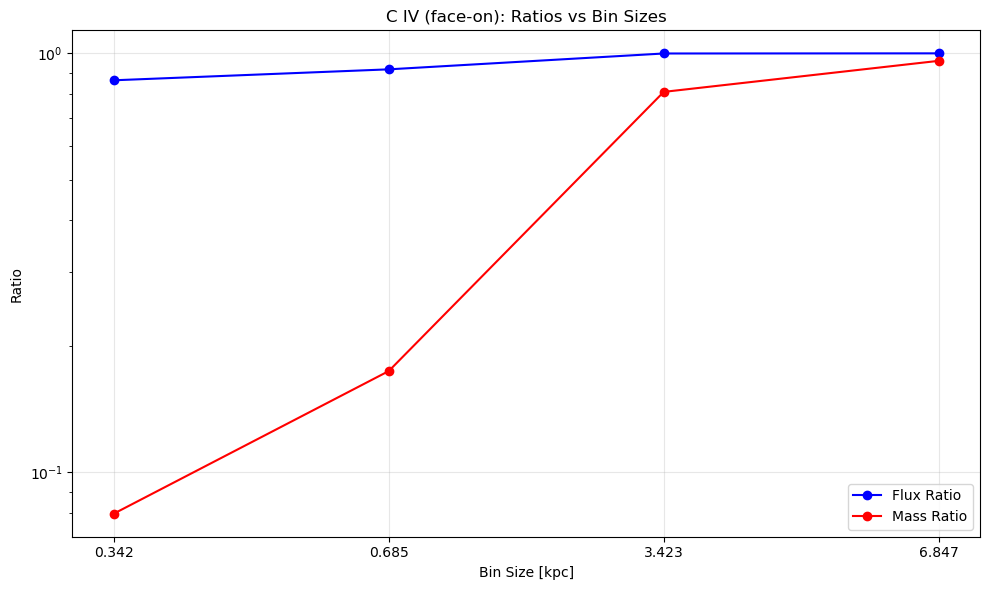

Ion: O VI
Orientation: edge
emission_data min 1211265277.7912488
Bin Size: 0.342 kpc
Total Flux: 1.20e+27, Flux Above Threshold: 1.03e+27, Flux Ratio: 0.86
Total Mass: 1.34e+05, Mass Above Threshold: 2.18e+03, Mass Ratio: 0.02
emission_data min 35067993296.33698
Bin Size: 0.685 kpc
Total Flux: 2.15e+27, Flux Above Threshold: 2.02e+27, Flux Ratio: 0.94
Total Mass: 1.34e+05, Mass Above Threshold: 7.01e+03, Mass Ratio: 0.05
emission_data min 2413924796833.167
Bin Size: 3.423 kpc
Total Flux: 3.32e+27, Flux Above Threshold: 3.31e+27, Flux Ratio: 1.00
Total Mass: 1.34e+05, Mass Above Threshold: 7.31e+04, Mass Ratio: 0.54
emission_data min 306437433980823.06
Bin Size: 6.847 kpc
Total Flux: 9.93e+27, Flux Above Threshold: 9.93e+27, Flux Ratio: 1.00
Total Mass: 1.37e+05, Mass Above Threshold: 1.08e+05, Mass Ratio: 0.79


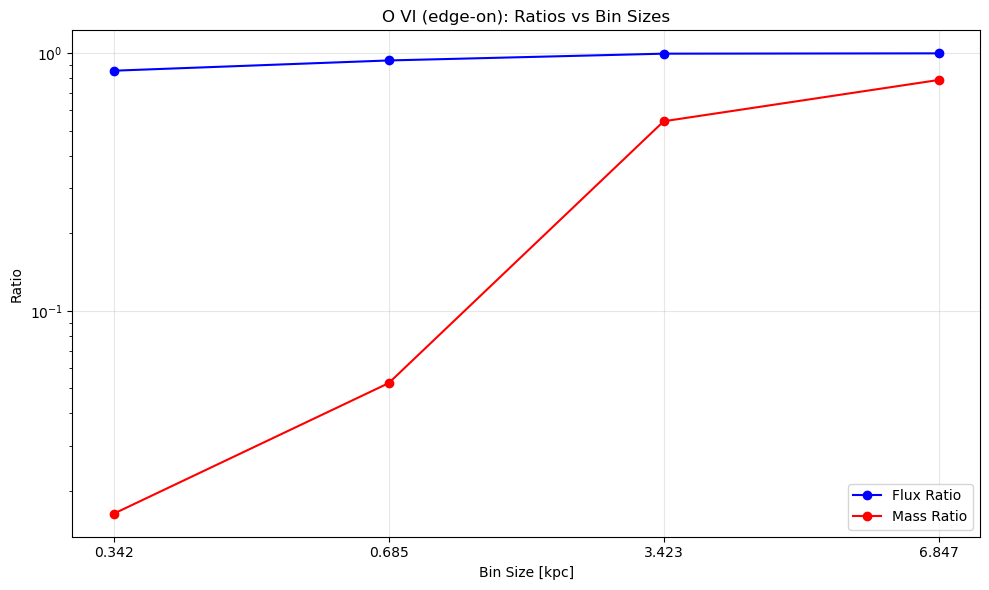

Orientation: face
emission_data min 57432708.350926094
Bin Size: 0.342 kpc
Total Flux: 1.44e+27, Flux Above Threshold: 1.26e+27, Flux Ratio: 0.87
Total Mass: 1.38e+05, Mass Above Threshold: 1.81e+03, Mass Ratio: 0.01
emission_data min 15304893526.303465
Bin Size: 0.685 kpc
Total Flux: 1.98e+27, Flux Above Threshold: 1.84e+27, Flux Ratio: 0.93
Total Mass: 1.38e+05, Mass Above Threshold: 6.62e+03, Mass Ratio: 0.05
emission_data min 4029553056485.36
Bin Size: 3.423 kpc
Total Flux: 4.13e+27, Flux Above Threshold: 4.12e+27, Flux Ratio: 1.00
Total Mass: 1.37e+05, Mass Above Threshold: 8.63e+04, Mass Ratio: 0.63
emission_data min 749369179563401.8
Bin Size: 6.847 kpc
Total Flux: 1.55e+28, Flux Above Threshold: 1.55e+28, Flux Ratio: 1.00
Total Mass: 1.35e+05, Mass Above Threshold: 1.15e+05, Mass Ratio: 0.85


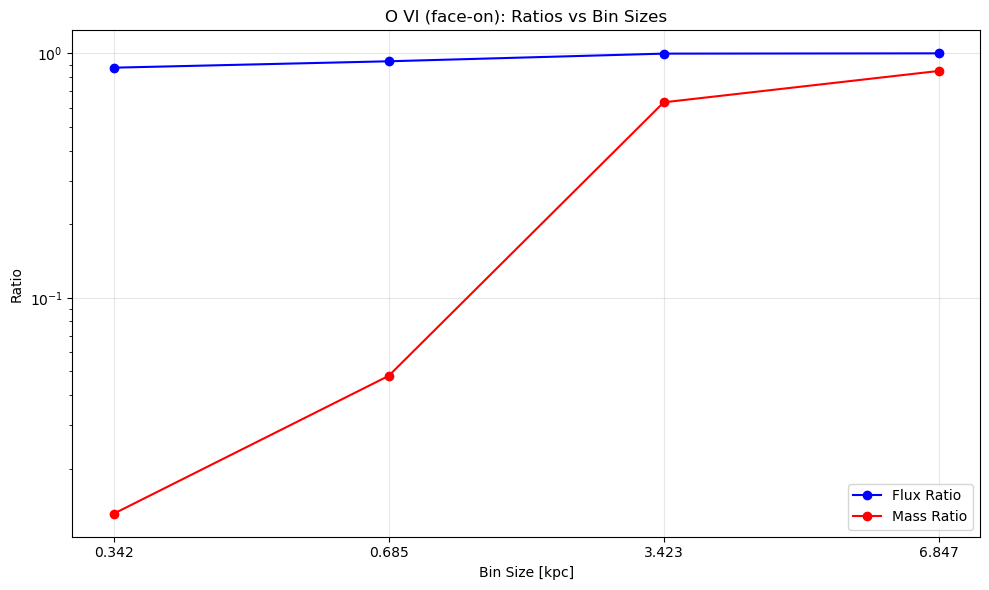

In [10]:
# Define parameters


# Lists to store results
flux_ratios = []
mass_ratios = []

# Iterate over ions and orientations
for ion in ions:
    print(f"Ion: {ion}")
    for orientation in orientations:
        print(f"Orientation: {orientation}")
        
        flux_ratio_list = []
        mass_ratio_list = []

        for i, bin_size_kpc in enumerate(bin_sizes):
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract emission and mass data
            with h5py.File(file_path, 'r') as f:
                emission_data = np.array(f[f"z=0.0/{ion}_emission_{orientation}_all"]).flatten()
                mass_data = np.array(f[f"z=0.0/{ion}_mass_{orientation}_all"]).flatten()
                valid_indices = (emission_data > 1e-140) & (mass_data > 1e-140)
                emission_data = emission_data[valid_indices]*((float(bin_size_kpc)*3.086e21)**2)
                print('emission_data min',emission_data.min())
                
                mass_data = mass_data[valid_indices]
                # Total flux and mass
                total_flux = emission_data.sum()
                total_mass = mass_data.sum()

                # Filter for flux above the threshold
                
                flux_above_threshold = emission_data[emission_data > flux_threshold].sum()
                mass_above_threshold = mass_data[emission_data > flux_threshold].sum()

                # Calculate ratios
                flux_ratio = flux_above_threshold / total_flux if total_flux > 0 else 0
                mass_ratio = mass_above_threshold / total_mass if total_mass > 0 else 0

                # Print metrics
                print(f"Bin Size: {bin_size_kpc} kpc")
                print(f"Total Flux: {total_flux:.2e}, Flux Above Threshold: {flux_above_threshold:.2e}, Flux Ratio: {flux_ratio:.2f}")
                print(f"Total Mass: {total_mass:.2e}, Mass Above Threshold: {mass_above_threshold:.2e}, Mass Ratio: {mass_ratio:.2f}")

                # Append to lists
                flux_ratio_list.append(flux_ratio)
                mass_ratio_list.append(mass_ratio)

        # Store ratios for this ion and orientation
        flux_ratios.append((ion, orientation, flux_ratio_list))
        mass_ratios.append((ion, orientation, mass_ratio_list))

        # Plot flux ratio and mass ratio vs bin sizes
        plt.figure(figsize=(10, 6))
        plt.plot(bin_sizes, flux_ratio_list, label='Flux Ratio', marker='o', linestyle='-', color='blue')
        plt.plot(bin_sizes, mass_ratio_list, label='Mass Ratio', marker='o', linestyle='-', color='red')
        plt.xlabel('Bin Size [kpc]')
        plt.ylabel('Ratio')
        plt.yscale('log')  # Optional: Use log scale if needed
        #plt.ylim(0.2,1.1)
        plt.title(f'{ion} ({orientation}-on): Ratios vs Bin Sizes')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "ratios_vs_bin_sizes", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_ratios.png"))
        plt.show()

# The flux_ratios and mass_ratios lists now contain data for all bin sizes.


In [11]:
# make surface brightness vs tempreture for all ions, each plot shows for different bining

for i, bin_size_kpc in enumerate(bin_sizes):
    print('bin size', bin_size)
    for orientation in orientations:
        print('orientation',orientation)
        for ion in ions:
            print('ion',ion)
            plt.figure(figsize=(10, 7))
        
            # Dataset names for mass and emission
            mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
            emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                temp_data = np.array(f[temp_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
            
            
                # Filter valid values
                valid_indices = (emission_data > 1e-40) & (temp_data > 1e-40)
                emission_data = emission_data[valid_indices]
                temp_data = temp_data[valid_indices]

                # Define log-spaced bins for emission
                temp_min = temp_data.min()
                temp_max = temp_data.max()
                bins = np.logspace(np.log10(temp_min), np.log10(temp_max), 64)

                # Calculate total mass per bin
                bin_indices = np.digitize(emission_data, bins)
                emission_per_bin = [emission_data[bin_indices == j].sum() for j in range(1, len(bins))]

                # Plot the results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.fill_between(bin_centers, emission_per_bin, step='mid', color=color, alpha=0.7,
                                    label=f'Bin Size: {bin_size_kpc} kpc')

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.ylabel('Surface Brightness [$erg/s/cm^2/arcsec^2$]')
        plt.xlabel('T [K]')
        plt.title(f'{ion} Mass vs Surface Brightness ({orientation}-on)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "emission_vs_temp_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_emission_vs_temp_plots.png"))
        plt.show()
        plt.close()


bin size 6.847 kpc
orientation edge
ion C IV


NameError: name 'temp_dataset_name' is not defined

<Figure size 1000x700 with 0 Axes>

In [2]:
# FOR HIGHEST RESOLUTION 

# make mass vs surfave brightness 
for ion in ions:
    print('ion',ion)
    for orientation in orientations:
        print('orientation',orientation)
        plt.figure(figsize=(10, 7))
        
        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
                total_surface_density = emission_data.sum()
                

                # Filter valid values
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
                emission_data = emission_data[valid_indices]
                mass_data = mass_data[valid_indices]

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 64)

                # Calculate total mass per bin
                bin_indices = np.digitize(emission_data, bins)
                mass_per_bin = [mass_data[bin_indices == j].sum() for j in range(1, len(bins))]

                # Plot the results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.fill_between(bin_centers, mass_per_bin, step='mid', color=color, alpha=0.7,
                                    label=f'Bin Size: {bin_size_kpc} kpc')

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Surface Brightness [$erg/s/cm^2/arcsec^2$]')
        plt.ylabel('Mass [$M_{sun}$]')
        plt.title(f'{ion} Mass vs Surface Brightness ({orientation}-on)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_mass_vs_emission.png"))
        plt.show()
        plt.close()
